<a href="https://colab.research.google.com/github/ramonVDAKKER/teaching-data-science-emas/blob/develop/notebook/illustration_decision_trees_splitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The basics of decision trees

This notebook contains snippets to facilitate a demo and discussion during a lecture. We focus on the technique and not on understanding the empirical application associated to the dataset we use.

## 0. Import packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.layers import Dense
from keras.models import Sequential

In [ ]:
%%capture
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension
import pandas_profiling

In [ ]:
%matplotlib inline

## 1. Load dataset

In [ ]:
data = load_breast_cancer()
y_df = pd.DataFrame(data.target, columns=["target"])
X_df = pd.DataFrame(data.data, columns=data.feature_names)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.3, random_state=123)
data_train_df = pd.concat([y_train_df, X_train_df], axis=1)

In [ ]:
print(f"The dataset, available for training, has {len(data_train_df)} rows and {data_train_df.shape[1]} columns.")
print("Some rows of the dataset:")
display(data_train_df.head(5))

## 2. Splitting mechanism illustrated

In [ ]:
def gini_impurity(y_left, y_right):
  p_L = np.mean(y_left.values)
  gini_left = 2 * p_L * (1 - p_L)
  p_R = np.mean(y_right.values)
  gini_right = 2 * p_R * (1 - p_R)
  n_right = len(y_right)
  weight_right = n_right / (len(y_left) + n_right)
  gini = weight_right * gini_right + (1 - weight_right) * gini_left
  return gini, gini_left, gini_right
def determine_gini_impurity_for_feature_and_split_ext(y, X_df, name_feature, threshold):
  left = (X_df[name_feature] <= threshold)
  y_left = y[left]
  y_right = y[~ left]
  return gini_impurity(y_left, y_right) 
def determine_gini_impurity_for_feature_and_split(y, X_df, name_feature, threshold):
  gini, _, _ = determine_gini_impurity_for_feature_and_split_ext(y, X_df, name_feature, threshold)
  return gini
vector_determine_gini_impurity_for_feature_and_split = np.vectorize(determine_gini_impurity_for_feature_and_split, excluded=["y", "X_df"])
def analyze_feature(X_df, name_feature, y):
  feature_values = X_df[name_feature].sort_values(ascending=True)[1:-1]
  gini = vector_determine_gini_impurity_for_feature_and_split(y=y, X_df=X_df, name_feature=name_feature, threshold=feature_values)
  plt.plot(feature_values, gini)
  plt.ylabel("Gini")
  plt.xlabel("Splitvalue")
  plt.title(f"Gini as function of possible split values for feature {name_feature}.")
  print(f"Split value: {feature_values.iloc[gini.argmin()]}")
  print(f"Gini: {gini.min()}")

Let us analyze a feature and evaluate how we should split for this feature:

In [ ]:
name_feature = "mean perimeter"
sns.histplot(data=data_train_df, x=name_feature, hue="target", multiple="stack")
plt.show()

The following graph shows how the Gini varies with the threshold:

In [ ]:
analyze_feature(X_train_df, name_feature, y_train_df)

In [9]:
def determine_best_split(y, X_df):
  out_df = pd.DataFrame(columns=["Gini", "Split"])
  for name_feature in X_df.columns:
    feature_values = X_df[name_feature].sort_values(ascending=True)[1:-1]
    gini = vector_determine_gini_impurity_for_feature_and_split(y=y, X_df=X_df, name_feature=name_feature, threshold=feature_values)
    out_df.loc[name_feature, "Split"] = feature_values.iloc[gini.argmin()]
    out_df.loc[name_feature, "Gini"] = gini.min()
  return out_df
display(determine_best_split(y_train_df, X_train_df).sort_values(by="Gini"))

,Gini,Split
worst radius,0.134778,16.77
worst area,0.138278,873.2
worst perimeter,0.143404,113.1
mean concave points,0.163761,0.04908
worst concave points,0.168242,0.1452
mean area,0.175888,693.7
mean perimeter,0.183713,98.22
mean radius,0.18409,15.0
area error,0.222897,39.93
mean concavity,0.227072,0.103


## 4. Train decision tree using Scikit

Let us check that Scikit finds the same answer for the first split. To this end we train a decision tree with 1 as maximum depth.

[Text(0.5, 0.75, 'X[20] <= 16.795\ngini = 0.462\nsamples = 398\nvalue = [144, 254]'),
 Text(0.25, 0.25, 'gini = 0.15\nsamples = 269\nvalue = [22, 247]'),
 Text(0.75, 0.25, 'gini = 0.103\nsamples = 129\nvalue = [122, 7]')]

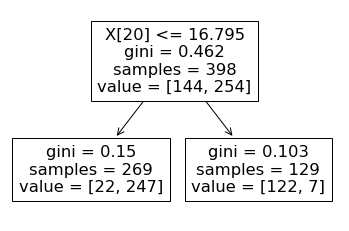

In [10]:
dtree = tree.DecisionTreeClassifier(max_depth=1)
dtree = dtree.fit(X_train_df, y_train_df)
tree.plot_tree(dtree) 

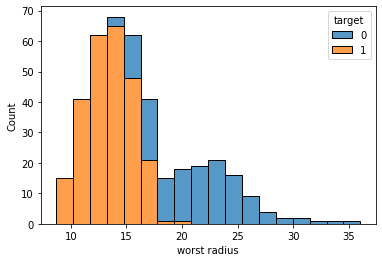

In [11]:
name_feature = X_train_df.columns[20]
sns.histplot(data=data_train_df, x=name_feature, hue="target", multiple="stack")

Let us check if our ad hoc code yields the same Gini for both leaves:

In [12]:
print(f"Gini before splitting:  {(2 * np.mean(y_train_df.values) * (1 - np.mean(y_train_df.values))):.03f}")
split_value = 16.795
gini, gini_left, gini_right = determine_gini_impurity_for_feature_and_split_ext(y_train_df, X_train_df, name_feature, split_value)
print(f"Gini left: {gini_left:.03f}.")
print(f"Gini right: {gini_right:.03f}.")
frac_left = np.mean(X_train_df[name_feature] <= split_value)
print(f"Gini after splitting: {frac_left * gini_left + (1 - frac_left) * gini_right:.03f}")

Gini before splitting:  0.462
Gini left: 0.150.
Gini right: 0.103.
Gini after splitting: 0.135


Now we understand how the decision tree comes to its splits, we train a "full" tree.

[Text(0.5454545454545454, 0.9444444444444444, 'X[20] <= 16.795\ngini = 0.462\nsamples = 398\nvalue = [144, 254]'),
 Text(0.2727272727272727, 0.8333333333333334, 'X[27] <= 0.136\ngini = 0.15\nsamples = 269\nvalue = [22, 247]'),
 Text(0.09090909090909091, 0.7222222222222222, 'X[18] <= 0.009\ngini = 0.033\nsamples = 236\nvalue = [4, 232]'),
 Text(0.045454545454545456, 0.6111111111111112, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.13636363636363635, 0.6111111111111112, 'X[21] <= 29.225\ngini = 0.025\nsamples = 235\nvalue = [3, 232]'),
 Text(0.09090909090909091, 0.5, 'gini = 0.0\nsamples = 199\nvalue = [0, 199]'),
 Text(0.18181818181818182, 0.5, 'X[6] <= 0.116\ngini = 0.153\nsamples = 36\nvalue = [3, 33]'),
 Text(0.13636363636363635, 0.3888888888888889, 'X[19] <= 0.001\ngini = 0.108\nsamples = 35\nvalue = [2, 33]'),
 Text(0.09090909090909091, 0.2777777777777778, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.18181818181818182, 0.2777777777777778, 'X[12] <= 1.467\ngini = 0.057\

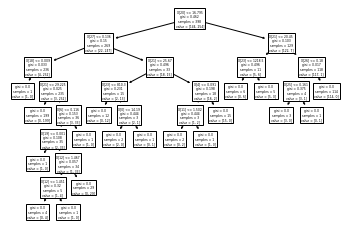

In [13]:
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_train_df, y_train_df)
tree.plot_tree(dtree) 

Use the tree to predict $Y$ for an observation $X$:

In [14]:
x = X_train_df.loc[0]
print("For\n\n")
print(x)
print(f"\n\nthe tree yields Y_hat={dtree.predict(x.values.reshape(1, -1))[0]}.")
print(f"The true outcome is {y_train_df.loc[0][0]}.")

For


mean radius                  17.990000
mean texture                 10.380000
mean perimeter              122.800000
mean area                  1001.000000
mean smoothness               0.118400
mean compactness              0.277600
mean concavity                0.300100
mean concave points           0.147100
mean symmetry                 0.241900
mean fractal dimension        0.078710
radius error                  1.095000
texture error                 0.905300
perimeter error               8.589000
area error                  153.400000
smoothness error              0.006399
compactness error             0.049040
concavity error               0.053730
concave points error          0.015870
symmetry error                0.030030
fractal dimension error       0.006193
worst radius                 25.380000
worst texture                17.330000
worst perimeter             184.600000
worst area                 2019.000000
worst smoothness              0.162200
worst compactness  

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


Now we "score" full dataset:

In [15]:
y_train_pred = dtree.predict(X_train_df)

In [16]:
print(y_train_pred)

[1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1
 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1
 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1
 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0
 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1
 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1
 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1
 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1
 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1]


Let us determine the confusion matrix:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


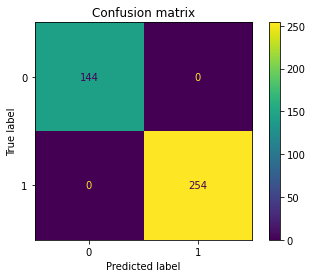

The accuracy is 100.00%.


In [17]:
class_names = [0, 1]
def confusion_matrix(model_object, X_df, y_df):
    disp = plot_confusion_matrix(model_object, X_df, y_df)
    disp.ax_.set_title("Confusion matrix")
    plt.show()
    y_hat = model_object.predict(X_df)
    accuracy = accuracy_score(y_df, y_hat, normalize=True)
    print(f"The accuracy is {100 * accuracy:0.2f}%.")
confusion_matrix(dtree, X_train_df, y_train_df)

Next we evaluate the model on the test data:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


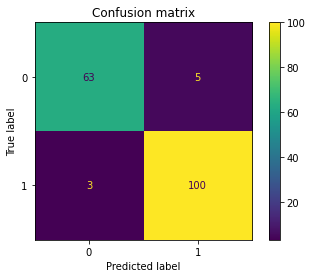

The accuracy is 95.32%.


In [18]:
confusion_matrix(dtree, X_test_df, y_test_df)

Let us also fit a decision tree with restricted depth and evaluate its performance on the train and test set:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


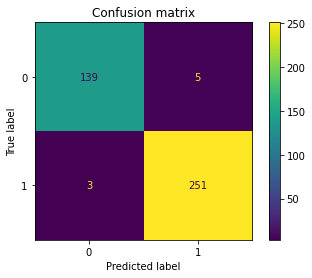

The accuracy is 97.99%.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


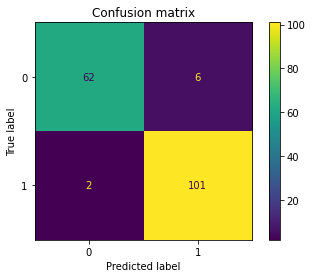

The accuracy is 95.32%.


In [19]:
dtree = tree.DecisionTreeClassifier(max_depth=3)
dtree = dtree.fit(X_train_df, y_train_df)
confusion_matrix(dtree, X_train_df, y_train_df)
confusion_matrix(dtree, X_test_df, y_test_df)